In [2]:
!git clone https://gitlab.com/ADrozdova/kws.git

import os
os.chdir("./kws")

!pip install -r requirements.txt -q

Cloning into 'kws'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 112 (delta 54), reused 104 (delta 46), pack-reused 0
Receiving objects: 100% (112/112), 47.40 KiB | 1.97 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [3]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(3407)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [117]:
import matplotlib.pyplot as plt
import torchaudio
import dataclasses

from thop import profile
from typing import Tuple

from src.model import CRNN
from train import train

from configs.config import TaskConfig
from src.log_mel_spec import LogMelspec
from src.distillation import distill_train_epoch


In [4]:
!./download_dataset.sh

--2021-11-22 12:28:56--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.119.128, 2a00:1450:4013:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.119.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   261MB/s    in 5.6s    

2021-11-22 12:29:02 (252 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
from  src.utils import download_models, download_music

download_models()
download_music()

# Train Base Model

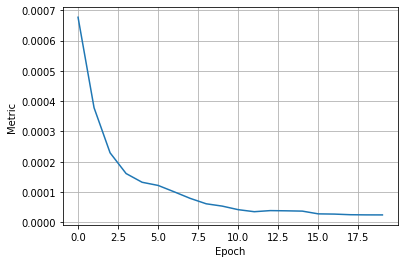

END OF EPOCH 19


In [ ]:
base_config = TaskConfig()

base_model, history_base = train(base_config, filename="base_model.pth")

In [ ]:
history_base['val_metric']

[0.0006768511817459881,
 0.00037795164227655373,
 0.00022908221654410066,
 0.00016062847824105343,
 0.00013181715851939775,
 0.00012136201515727249,
 0.00010033237748139953,
 7.865824466676542e-05,
 6.07675370185625e-05,
 5.309327082923996e-05,
 4.133123454684905e-05,
 3.4611775970505995e-05,
 3.824601244740912e-05,
 3.7541841832836755e-05,
 3.6545261386789434e-05,
 2.7474589063484414e-05,
 2.673461316342532e-05,
 2.4645971510032715e-05,
 2.4132762418056245e-05,
 2.4007443918852692e-05]

# Streaming

In [ ]:
sheila_wav, sr = torchaudio.load("./speech_commands/sheila/004ae714_nohash_0.wav")
sound_wav, sr = torchaudio.load("gayazov_brothers_deep_house.wav")

transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000) 
sound_wav = transform(sound_wav)

sound_wav = sound_wav.mean(dim=0, keepdim=True) # convert to mono

wav = torch.cat([sound_wav, sheila_wav, sound_wav], dim=1)

wav = wav.cuda()

log_melspec = LogMelspec(is_train=False, config=TaskConfig)
wav_spec = log_melspec(wav)

In [ ]:
from src.streaming import StreamKWS
streamer = StreamKWS(base_model, 128, 32)

probs = streamer.stream(wav_spec)

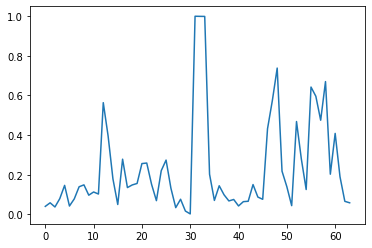

In [ ]:
probs = probs.cpu()

plt.plot(np.arange(len(probs[:, 1])), probs[:, 1])
plt.show()

In [168]:
from configs.config import TaskConfig
from src.model import CRNN

conf = TaskConfig()
base_model = CRNN(conf).to(conf.device)

base_model.load_state_dict(torch.load("base_model.pth"))

<All keys matched successfully>

# Distillation

In [82]:
@dataclasses.dataclass
class ConfigDistill:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 40
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 20
    gru_num_layers: int = 1
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    alpha: float = 0.95
    temperature: int = 6
    distill_attn: bool = False
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

config_distill = ConfigDistill()

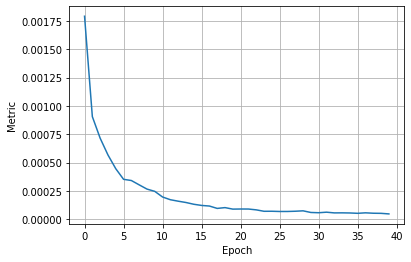

END OF EPOCH 39


In [ ]:
student_model, history = train(config_distill, train_epoch_fn=distill_train_epoch, teacher_model=base_model, filename="student_model.pth")

In [ ]:
history['val_metric']

[0.0017926125043096883,
 0.0009055813129828026,
 0.0007150494538127482,
 0.0005669558092658409,
 0.00044538791371701974,
 0.0003516377412175975,
 0.0003409826850115047,
 0.00030268296463586546,
 0.0002652932952663473,
 0.00024515878972764264,
 0.00019523727043776885,
 0.00017126264803061229,
 0.00015832202110094984,
 0.00014667933577018142,
 0.00013118459847579882,
 0.00012080404945843761,
 0.00011550785098019207,
 9.456175897045482e-05,
 0.00010157959492585397,
 8.824809362962804e-05,
 8.928047936116208e-05,
 8.904177745791722e-05,
 8.176136940894872e-05,
 6.911613608455178e-05,
 6.942644855877012e-05,
 6.745715785699995e-05,
 6.752578465418286e-05,
 6.954878328418313e-05,
 7.318003598729568e-05,
 5.8631154984520926e-05,
 5.635751935611356e-05,
 6.119123289682214e-05,
 5.493127548422545e-05,
 5.534303626732286e-05,
 5.4221137322071975e-05,
 5.122542843634887e-05,
 5.549819250443202e-05,
 5.192363150334011e-05,
 5.093898615245503e-05,
 4.5890440898826044e-05]

In [83]:
student_model = CRNN(config_distill).to(config_distill.device)

student_model.load_state_dict(torch.load("student_model.pth"))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [91]:
from src.mem_estimation import get_size_in_megabytes
base_size = get_size_in_megabytes(base_model)
student_size = get_size_in_megabytes(student_model)

print("Base model size", base_size, ", distilled model size", student_size)

print("base size / student size", base_size / student_size)

Base model size 0.2687187194824219 , distilled model size 0.024898529052734375
base size / student size 10.792554006434809


In [96]:
batch = torch.randn(128, 40, 101) # batch shape
batch = batch.cuda()
base_macs, base_params = profile(base_model, (batch, ))

print("\nBase model macs", base_macs, "\nBase model params", base_params, "\n")

macs, params = profile(student_model, (batch, ))

print("\nStudent model macs", macs, "\nStudent model params", params)
print("Base macs / student macs = ", base_macs / macs, "\n")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.model.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.model.CRNN'>. Treat it as zero Macs and zero Params.

Base model macs 119527424.0 
Base model params 70443.0 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] 

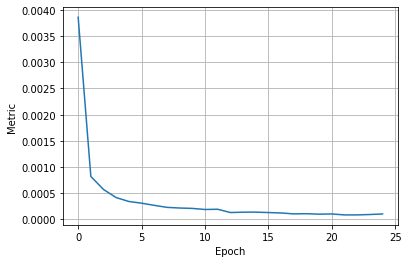

END OF EPOCH 24


In [21]:
@dataclasses.dataclass
class ConfigDistillAttn:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 8e-4
    weight_decay: float = 0
    num_epochs: int = 25
    n_mels: int = 40
    cnn_out_channels: int = 2
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 16
    gru_num_layers: int = 1
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    alpha: float = 0.6
    temperature: int = 0.8
    distill_attn: bool = True
    beta: float = 5.0
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    

config_distill_attn = ConfigDistillAttn()

student_model_attn, history_attn = train(config_distill_attn, train_epoch_fn=distill_train_epoch, teacher_model=base_model, filename="student_model_attn.pth")

In [22]:
history_attn['val_metric']

[0.0038659324792877613,
 0.0008132693194504307,
 0.0005631634327780382,
 0.0004079534877406432,
 0.0003335053478923592,
 0.0003009314894208063,
 0.0002595704171360516,
 0.00022101409221442412,
 0.000208309183414216,
 0.000200909424413625,
 0.00018028557997326836,
 0.00018451657120828368,
 0.0001217558732976265,
 0.00012849323451671294,
 0.0001297762572466541,
 0.00012129637213388015,
 0.0001134013066840561,
 9.586865189072047e-05,
 9.945514798697463e-05,
 9.015770885558699e-05,
 9.428128423414208e-05,
 7.603849127865298e-05,
 7.637864149077693e-05,
 8.356356877844749e-05,
 9.469901256482061e-05]

In [23]:
from src.mem_estimation import get_size_in_megabytes
base_size = get_size_in_megabytes(base_model)
student_size = get_size_in_megabytes(student_model_attn)

print("Base model size", base_size, ", distilled model size", student_size)

print("base size / student size", base_size / student_size)

Base model size 0.2687187194824219 , distilled model size 0.011890411376953125
base size / student size 22.59961501443696


In [24]:
base_macs, base_params = profile(base_model, (batch, ))

print("\nBase model macs", base_macs, "\nBase model params", base_params, "\n")

macs, params = profile(student_model_attn, (batch, ))

print("\nStudent model macs", macs, "\nStudent model params", params)
print("Base macs / student macs = ", base_macs / macs, "\n")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.model.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.model.CRNN'>. Treat it as zero Macs and zero Params.

Base model macs 119527424.0 
Base model params 70443.0 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] 

# Quantization

In [86]:
# Quantize base model

from copy import deepcopy

base_model_cpu = deepcopy(base_model)
base_model_cpu = base_model_cpu.cpu() # Quantized models in torch are only on CPU now

quantized_model = torch.quantization.quantize_dynamic(
    base_model_cpu, {torch.nn.Linear, torch.nn.GRU}, dtype=torch.qint8
)

torch.save(quantized_model.state_dict(), "quantized_model.pth")

In [73]:
# This is probably incorrect, because we use CPU and GPU, but just checking.
# MACs for quantzed model should be the same.

batch_cpu = deepcopy(batch)
batch_cpu = batch_cpu.cpu()

basebase_macs, base_params = profile(base_model, (batch, ))

print("\nBase model macs", base_macs, "\nBase model params", base_params, "\n")

macs, params = profile(quantized_model, (batch_cpu, ))

print("\nStudent model macs", macs, "\nQuantized model params", params)
print("Base macs / quantized macs = ", base_macs / macs, "\n")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.model.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'src.model.CRNN'>. Treat it as zero Macs and zero Params.

Base model macs 119527424.0 
Base model params 70443.0 

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] 

In [76]:
os.path.getsize("base_model.pth") / os.path.getsize("quantized_model.pth")

3.0794937966332294

In [87]:
# Quantize distilled student model

student_model_cpu = deepcopy(student_model)
student_model_cpu = student_model_cpu.cpu() # Quantized models in torch are only on CPU now

quantized_distilled_model = torch.quantization.quantize_dynamic(
    student_model_cpu, {torch.nn.Linear, torch.nn.GRU}, dtype=torch.qint8
)

torch.save(quantized_distilled_model.state_dict(), "quantized_distilled_model.pth")

In [88]:
os.path.getsize("base_model.pth") / os.path.getsize("quantized_distilled_model.pth")

20.187937991080908

In [104]:
from src.train import validation

def check_quantized(model):
    dataset = SpeechCommandDataset(
        path2dir='speech_commands', keywords=TaskConfig.keyword
    )

    indexes = torch.randperm(len(dataset))
    val_indexes = indexes[int(len(dataset) * 0.8):]

    val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

    val_set = SpeechCommandDataset(csv=val_df)

    val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                            shuffle=False, collate_fn=Collator(),
                            num_workers=2, pin_memory=True)
    conf = TaskConfig
    conf.device = torch.device("cpu")
    melspec_val = LogMelspec(is_train=False, config=TaskConfig)

    return validation(model, val_loader, melspec_val, torch.device("cpu"))

In [110]:
check_quantized(quantized_model)

102it [00:09, 11.18it/s]


2.6460105974693716e-05

In [109]:
check_quantized(quantized_distilled_model)

102it [00:08, 11.52it/s]


4.704814512956366e-05

In [112]:
results = {
    "base" : {
        "quality" : 2.4e-5,
        "Memory" : 1.0,
        "fLOPs" : 1.0
    },
    "distilled" : { # Student
        "quality" : 4.6e-05,
        "Memory" : 1.0 / 10.79,
        "fLOPs" : 1.0 / 6.29
    },
    "quantized" : {
        "quality" : 2.6e-5,
        "Memory" : 1.0 / 3.07,
        "fLOPs" : 1.0 # same as base
    },
    "distilled + quantized" : {
        "quality" : 4.7e-05,
        "Memory" : 1.0 / 20.18,
        "fLOPs" : 1.0 / 6.29 # same as distilled
    },
    "distilled + attention" : { # Student
        "quality" : 7.6e-05,
        "Memory" : 1.0 / 22.59,
        "fLOPs" : 1.0 / 12.83
    }
}

In [113]:
results.items()

dict_items([('base', {'quality': 2.4e-05, 'Memory': 1.0, 'fLOPs': 1.0}), ('distilled', {'quality': 4.6e-05, 'Memory': 0.09267840593141799, 'fLOPs': 0.1589825119236884}), ('quantized', {'quality': 2.6e-05, 'Memory': 0.32573289902280134, 'fLOPs': 1.0}), ('distilled + quantized', {'quality': 4.7e-05, 'Memory': 0.049554013875123884, 'fLOPs': 0.1589825119236884}), ('distilled + attention', {'quality': 7.6e-05, 'Memory': 0.04426737494466578, 'fLOPs': 0.0779423226812159})])

In [128]:
quality = [res["quality"] * 1e5 for _, res in results.items()]
memory = [res["Memory"] for _, res in results.items()]
flops = [res["fLOPs"] for _, res in results.items()]

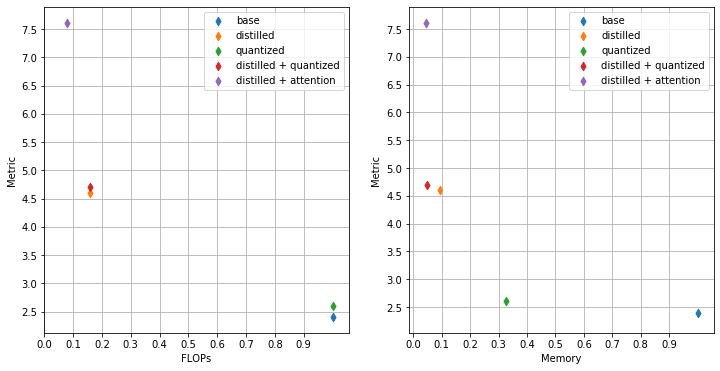

In [157]:
plt.figure(figsize=(12, 6))

ax = plt.subplot(121)
for name, x, y in zip(results.keys(), flops, quality):
    plt.scatter(x, y, marker="d", label=name)

ax.set(xlabel="FLOPs", ylabel="Metric")
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(2.5, 8, step=0.5))
ax.grid()
plt.legend()

ax = plt.subplot(122)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(2.5, 8, step=0.5))
for name, x, y in zip(results.keys(), memory, quality):
    plt.scatter(x, y, marker="d", label=name)

plt.legend()

ax.set(xlabel="Memory", ylabel="Metric ")
ax.grid()
plt.show()